# Set up a for fun test run with smoothed iceshelf draft crevasses

In [68]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.interpolation import extend_into_mask

Load files

In [2]:
folder   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'
domcfg   = xr.open_dataset(f'{folder}domain_cfg-20231025.nc')
meshmask = xr.open_dataset(f'{folder}mesh_mask-20231025.nc')

### Visualize crevasses

Text(0.5, 1.0, 'Ross ice shelf')

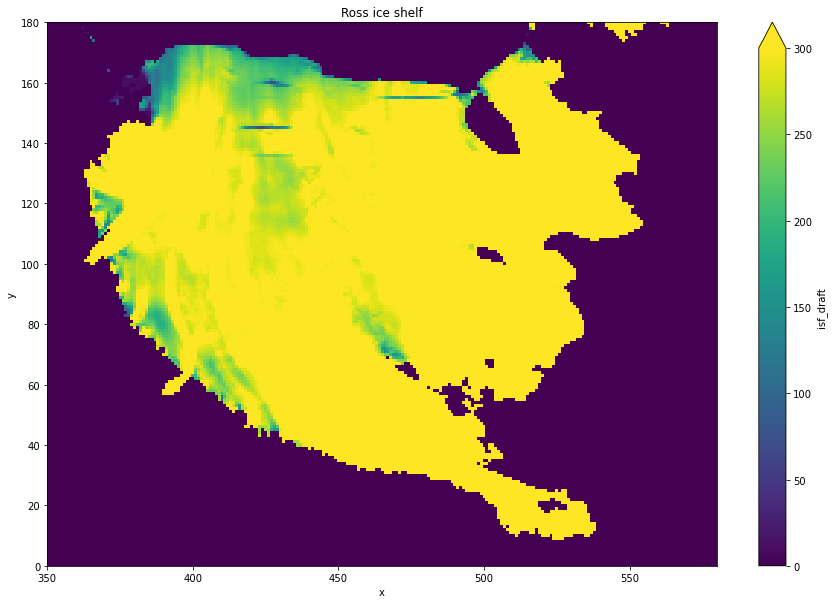

In [27]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
domcfg.isf_draft.isel(time_counter=0).plot(ax=ax, xlim=(350, 580), ylim=(0, 180), vmin=0, vmax=300)
ax.set_title('Ross ice shelf')

Text(0.5, 1.0, 'Filchner-Ronne ice shelf')

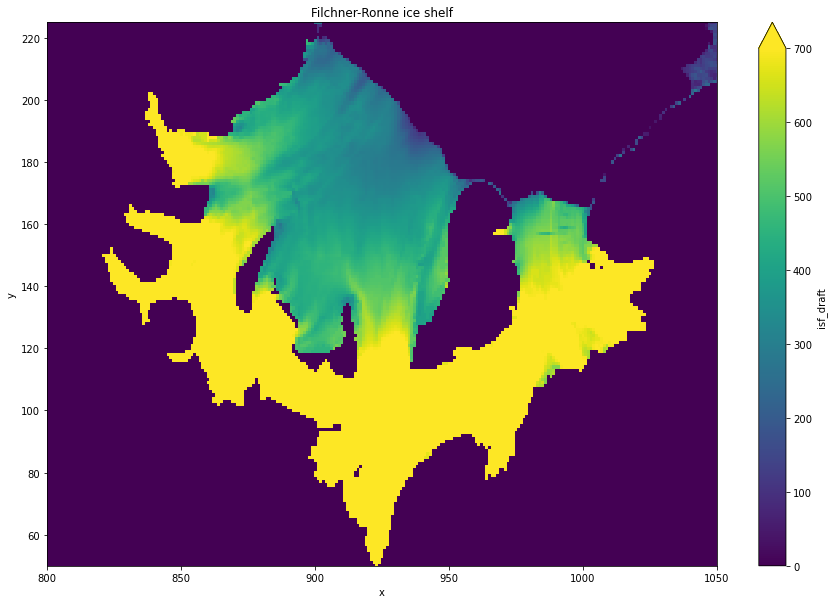

In [22]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
domcfg.isf_draft.isel(time_counter=0).plot(ax=ax, xlim=(800, 1050), ylim=(50, 225), vmin=0, vmax=700)
ax.set_title('Filchner-Ronne ice shelf')
# ax.plot([1326],[309], '*r', markersize=10);

In [80]:
isfdraft = domcfg.isf_draft.copy()

isfdraft.loc[dict(time_counter=0, x=slice(464,489), y=155)] = -9999
isfdraft.loc[dict(time_counter=0, x=slice(417,435), y=145)] = -9999
isfdraft.loc[dict(time_counter=0, x=slice(423,432), y=160)] = -9999
isfdraft.loc[dict(time_counter=0, x=slice(427,435), y=159)] = -9999
isfdraft.loc[dict(time_counter=0, x=slice(427,429), y=161)] = -9999
isfdraft.loc[dict(time_counter=0, x=slice(421,435), y=136)] = -9999

Text(0.5, 1.0, 'Ross ice shelf')

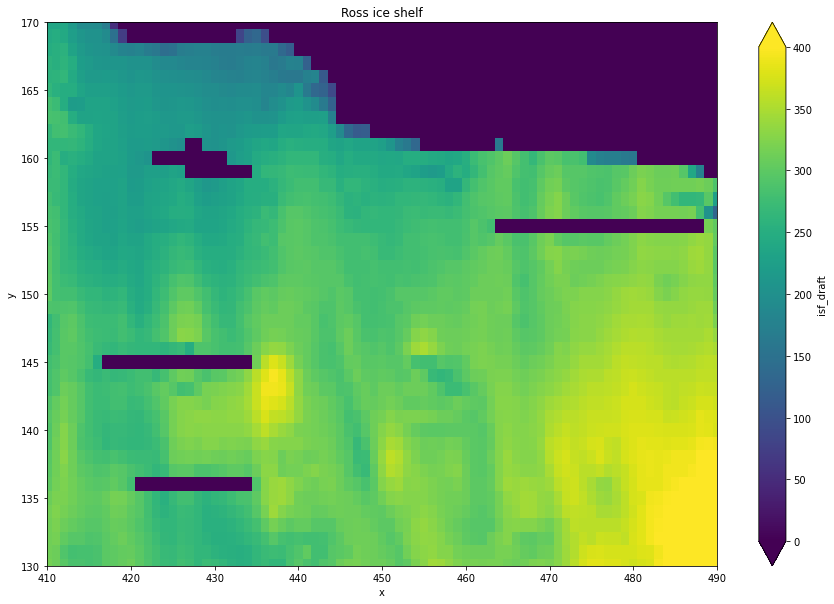

In [81]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
isfdraft.isel(time_counter=0).plot(ax=ax, xlim=(410, 490), ylim=(130, 170), vmin=0, vmax=400)
ax.set_title('Ross ice shelf')

Now fill these points with the nearest neighbour:

In [85]:
# Fill gaps in source dataset with nearest neighbour
var_filled  = extend_into_mask(isfdraft.isel(time_counter=0).values, missing_val=-9999, fill_val=np.nan, use_2d=True, use_3d=False, num_iters=50) 

  4%|▍         | 2/50 [00:00<00:02, 21.78it/s]

Completed filling missing values


Text(0.5, 1.0, 'Ross ice shelf')

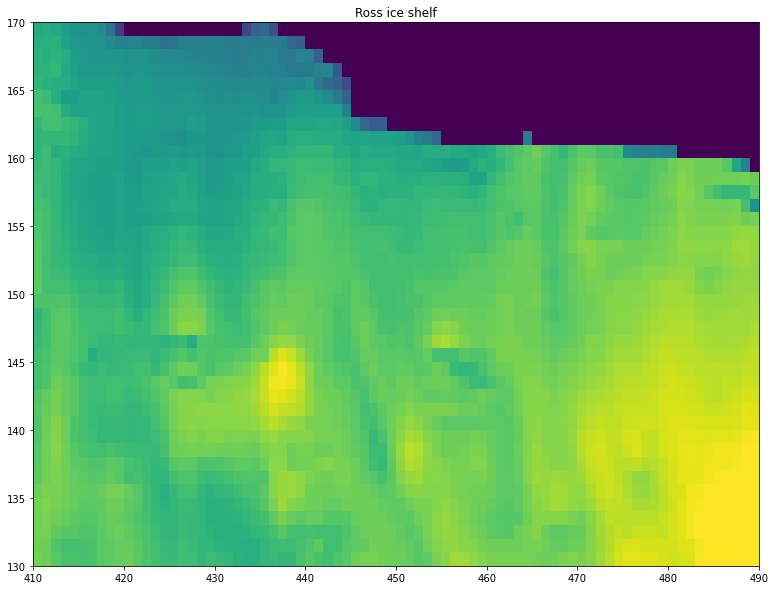

In [92]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
ax.pcolormesh(var_filled, vmin=0, vmax=400) 
ax.set_xlim(410, 490)
ax.set_ylim(130, 170)
ax.set_title('Ross ice shelf')

Now, apply this fill approach to each of the relevant variables and write back to file:

In [152]:
def fill_crevasse(array, dim='2D'):

    shift=0
    if dim=='2D':
        array[0,slice(464,489),155+shift] = -9999
        array[0,slice(417,435),145+shift] = -9999
        array[0,slice(423,432),160+shift] = -9999
        array[0,slice(427,435),159+shift] = -9999
        array[0,slice(427,429),161+shift] = -9999
        array[0,slice(421,435),136+shift] = -9999
    
        # var_filled = extend_into_mask(array[0,:,:], missing_val=-9999, fill_val=np.nan, use_2d=True, use_3d=False, num_iters=10) 
        # array[0, :, :] = var_filled
    elif dim=='3D':
        array[0,:,slice(464,489),155+shift] = -9999
        array[0,:,slice(417,435),145+shift] = -9999
        array[0,:,slice(423,432),160+shift] = -9999
        array[0,:,slice(427,435),159+shift] = -9999
        array[0,:,slice(427,429),161+shift] = -9999
        array[0,:,slice(421,435),136+shift] = -9999

        # var_filled = extend_into_mask(array[0,:,:,:], missing_val=-9999, fill_val=np.nan, use_2d=False, use_3d=True, num_iters=10) 
        # array[0, :, :, :] = var_filled
    else:
        raise Exception('Only set up for dimension 2D or 3D')

    return array

In [153]:
# ---- Domain config file ------------
domcfg_new   = domcfg.copy()
for var in ['bottom_level', 'bathy_metry', 'isf_draft', 'top_level']:
    new_array       = fill_crevasse(domcfg[var].values, dim='2D')
    domcfg_new[var] = (('time_counter', 'y', 'x'), new_array)

# domcfg_new.to_netcdf(f'{folder}domain_cfg-20240314-fun.nc')

# ---- Mesh mask file ------------
meshmask_new = meshmask.copy()
for var in ['bathy_metry', 'mbathy', 'misf', 'mhw', 'hw', 'tmaskutil', 'umaskutil', 'vmaskutil']:
    new_array         = fill_crevasse(meshmask[var].values, dim='2D')
    meshmask_new[var] = (('time_counter', 'y', 'x'), new_array)

for var in ['tmask', 'umask', 'vmask', 'fmask']:
    new_array         = fill_crevasse(meshmask[var].values, dim='3D')
    meshmask_new[var] = (('time_counter', 'nav_lev', 'y', 'x'), new_array)

# meshmask_new.to_netcdf(f'{folder}mesh_mask-20240314-fun.nc')

Text(0.5, 1.0, 'Ross ice shelf')

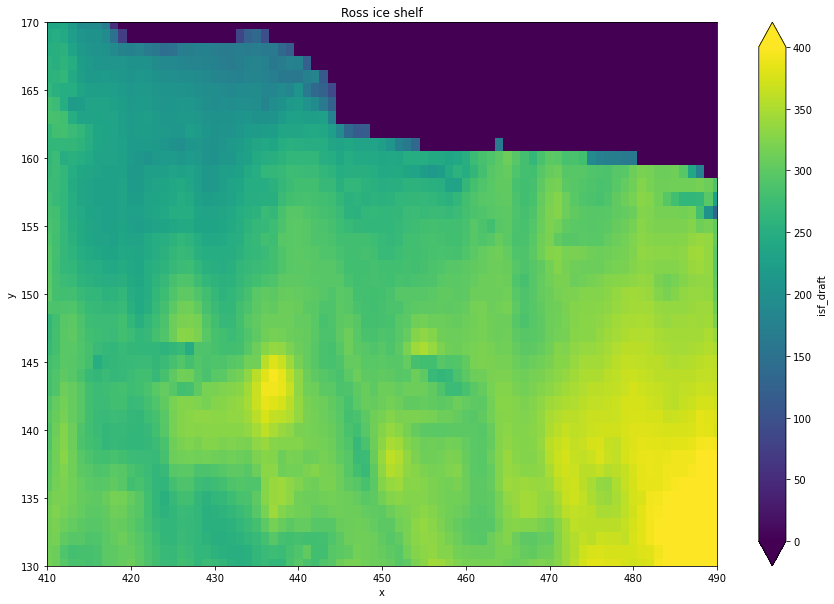

In [154]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
domcfg_new.isf_draft.isel(time_counter=0).plot(ax=ax, xlim=(410, 490), ylim=(130, 170), vmin=0, vmax=400)
ax.set_title('Ross ice shelf')

Text(0.5, 1.0, 'Ross ice shelf')

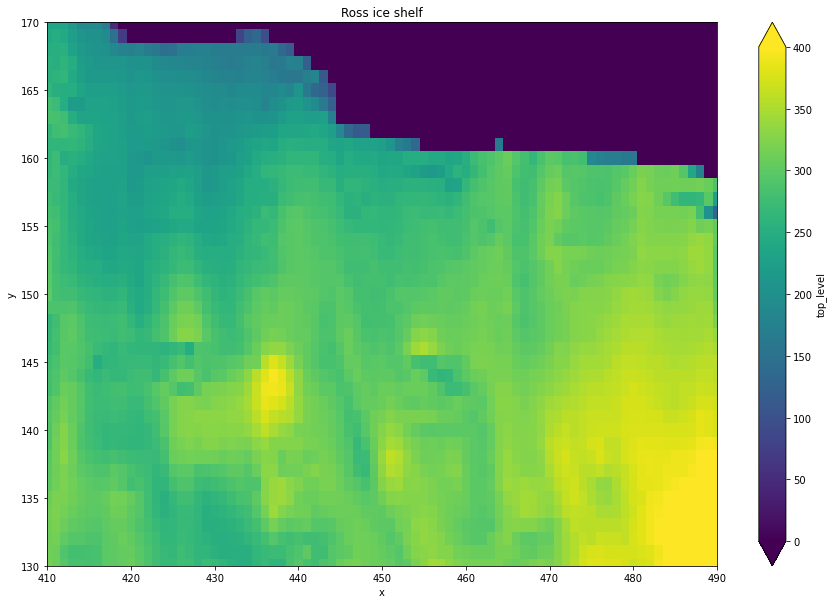

In [155]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
domcfg_new.top_level.isel(time_counter=0).plot(ax=ax, xlim=(410, 490), ylim=(130, 170), vmin=0, vmax=400)
ax.set_title('Ross ice shelf')

Text(0.5, 1.0, 'Ross ice shelf')

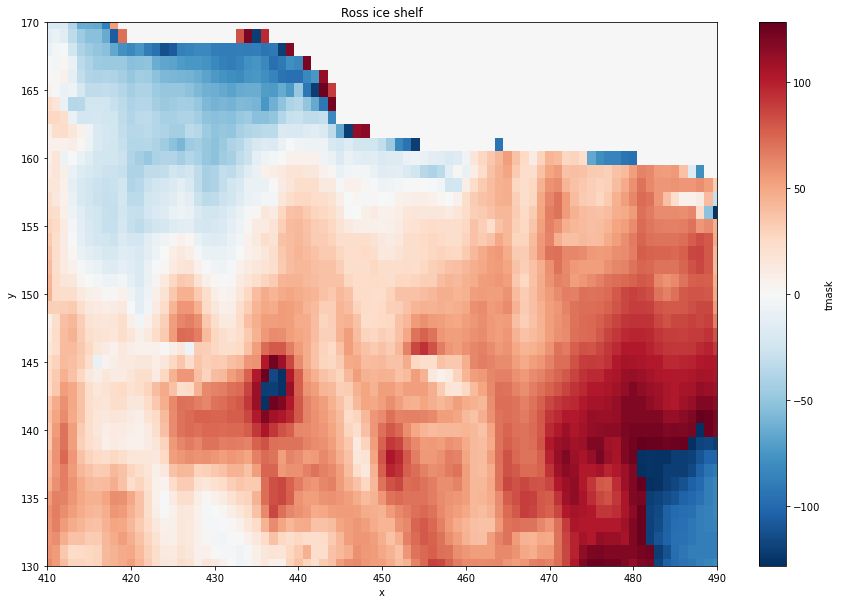

In [157]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
meshmask_new.tmask.isel(time_counter=0, nav_lev=0).plot(ax=ax, xlim=(410, 490), ylim=(130, 170))
ax.set_title('Ross ice shelf')